In [1]:
import os
import pickle
from src.utils.data import *
from src.utils.loader import *
from src.utils.cv_utils import *

In [2]:
os.listdir('data/ds')

['test-1144.pkl',
 'singles-valid-2417.pkl',
 'pairs-valid-1224.pkl',
 'singles-train-14707.pkl',
 'valid-1155.pkl',
 'singles-test-2472.pkl',
 'pairs-test-1251.pkl',
 'train-9252.pkl',
 'pairs-train-9734.pkl']

In [3]:
# dataset_train = pickle.load(open('data/ds/train-9252.pkl', 'rb'), encoding='bytes')
dataset_valid = pickle.load(open('data/ds/valid-1155.pkl', 'rb'), encoding='bytes')
dataset_test = pickle.load(open('data/ds/test-1144.pkl', 'rb'), encoding='bytes')

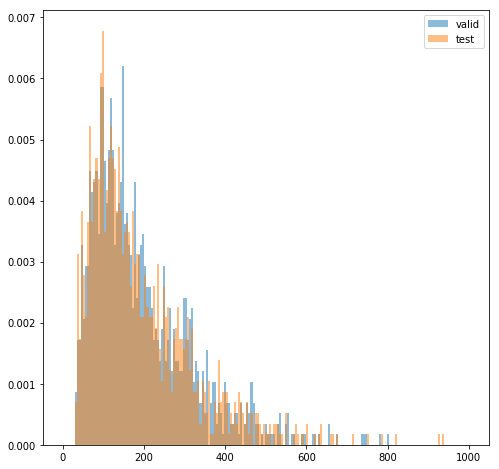

In [4]:
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

bins = np.linspace(0, 1000, 200)

# plt.hist([len(d[b'seqres']) for d in dataset_train], bins, alpha=0.5, label='train', density=1)
plt.hist([len(d[b'seqres']) for d in dataset_valid], bins, alpha=0.5, label='valid', density=1)
plt.hist([len(d[b'seqres']) for d in dataset_test], bins, alpha=0.5, label='test', density=1)

plt.legend(loc='upper right')
plt.show()

In [5]:
loader = XuLoader(dataset_valid)

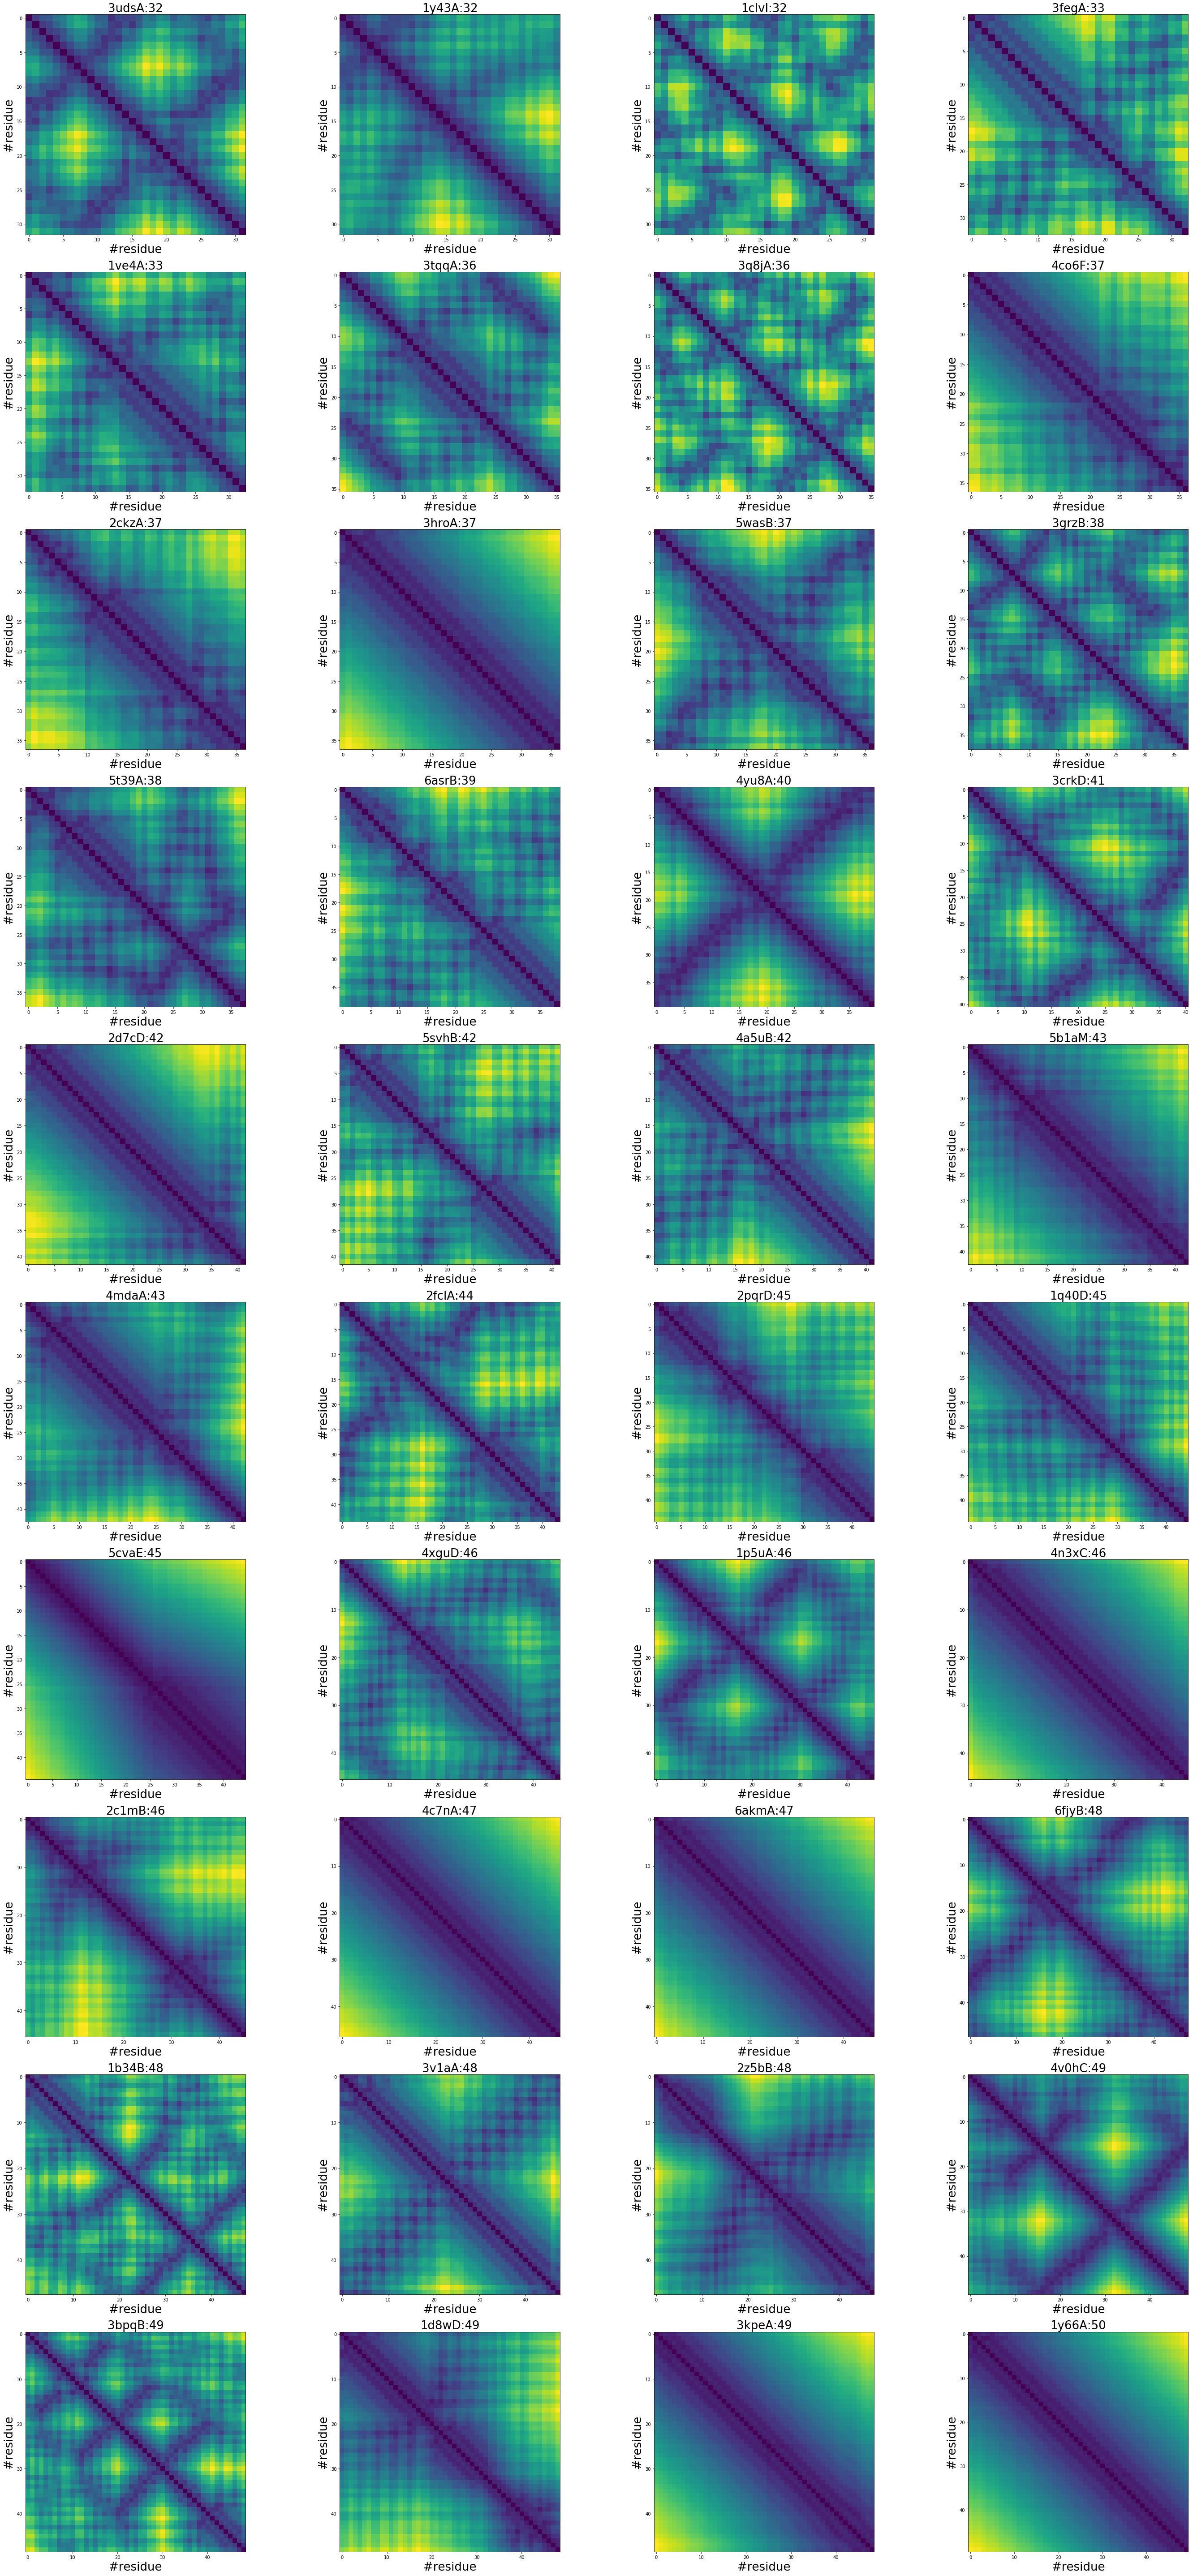

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams

N, K = 10, 4
rcParams['figure.figsize'] = 40, 40 * (N // K)

def display(ax, mat, title):
    ax.set_title(title, fontsize=26)
    ax.set_xlabel('#residue', fontsize=26)
    ax.set_ylabel('#residue', fontsize=26)
    ax.imshow(mat)

f, axarr = plt.subplots(N, K)

i = 0

while i < N * K:
    
    meta, data = next(loader)
    prof, dmat = data
    pdb, seq = meta

    display(axarr[i//K, i%K], dmat, '%s:%d' % (pdb, len(seq)))

    i += 1
    
plt.tight_layout()

In [7]:
from src.utils.data_utils import filter_pair_dataset

dataset_pairs = filter_pair_dataset(pickle.load(open('data/ds/pairs-valid-1224.pkl', 'rb'), encoding='bytes'), 0.99)

unique seq-pairs filtered: 100%|██████████| 945/945 [00:00<00:00, 3747.33it/s]


In [10]:
loader = PairsLoader(dataset_pairs)

In [11]:
meta, data = next(loader)

In [12]:
seq1, seq2, prof1, prof2, dmat1, dmat2, mutix = data
pdb_id1, pdb_id2, seq1, seq2 = meta
pdb_id1, pdb_id2

('1vcrA', '2bhwC')

In [13]:
a, b, size, diff = find_maximal_matching_shift(seq1, seq2, k=1)

In [14]:
a, b, size, diff

(0, 0, 34, [24])

In [15]:
seq1

'PETFSKNRELEVIHSRWAMLGALGCVFPELLSRN'

In [16]:
seq2

'PETFSKNRELEVIHSRWAMLGALGSVFPELLSRN'

In [17]:
from tqdm import tqdm
import random
random.seed(101)

lim = 4
maps = []
pbar = tqdm(total=lim, desc='pairs loaded')
for i, (meta, data) in enumerate(loader):
    pdb1, pdb2, seq1, seq2 = meta
    *_, prof1, prof2, m1, m2, mut_ix = data
    assert m1.shape == m2.shape
    maps.append([m1.data.numpy(), m2.data.numpy(), pdb1, pdb2, seq1, seq2, mut_ix])
    if i == lim:
        break
    pbar.update(1)
pbar.close()

pairs loaded: 100%|██████████| 4/4 [00:00<00:00, 2984.21it/s]


In [18]:
def compute_weight_matrix(mat):
    mat = mat.unsqueeze(0)
    m, n = mat.size(1), mat.size(2)
    assert m == n
    shift_mat = torch.max(torch.relu(mat), torch.relu(-mat))
    shift_mat = shift_mat.unsqueeze(1).repeat(1, n, 1, 1)
    msk = torch.max(shift_mat.sum(2), shift_mat.sum(3).transpose(1, 2))
    return msk.squeeze(0).div_(n)

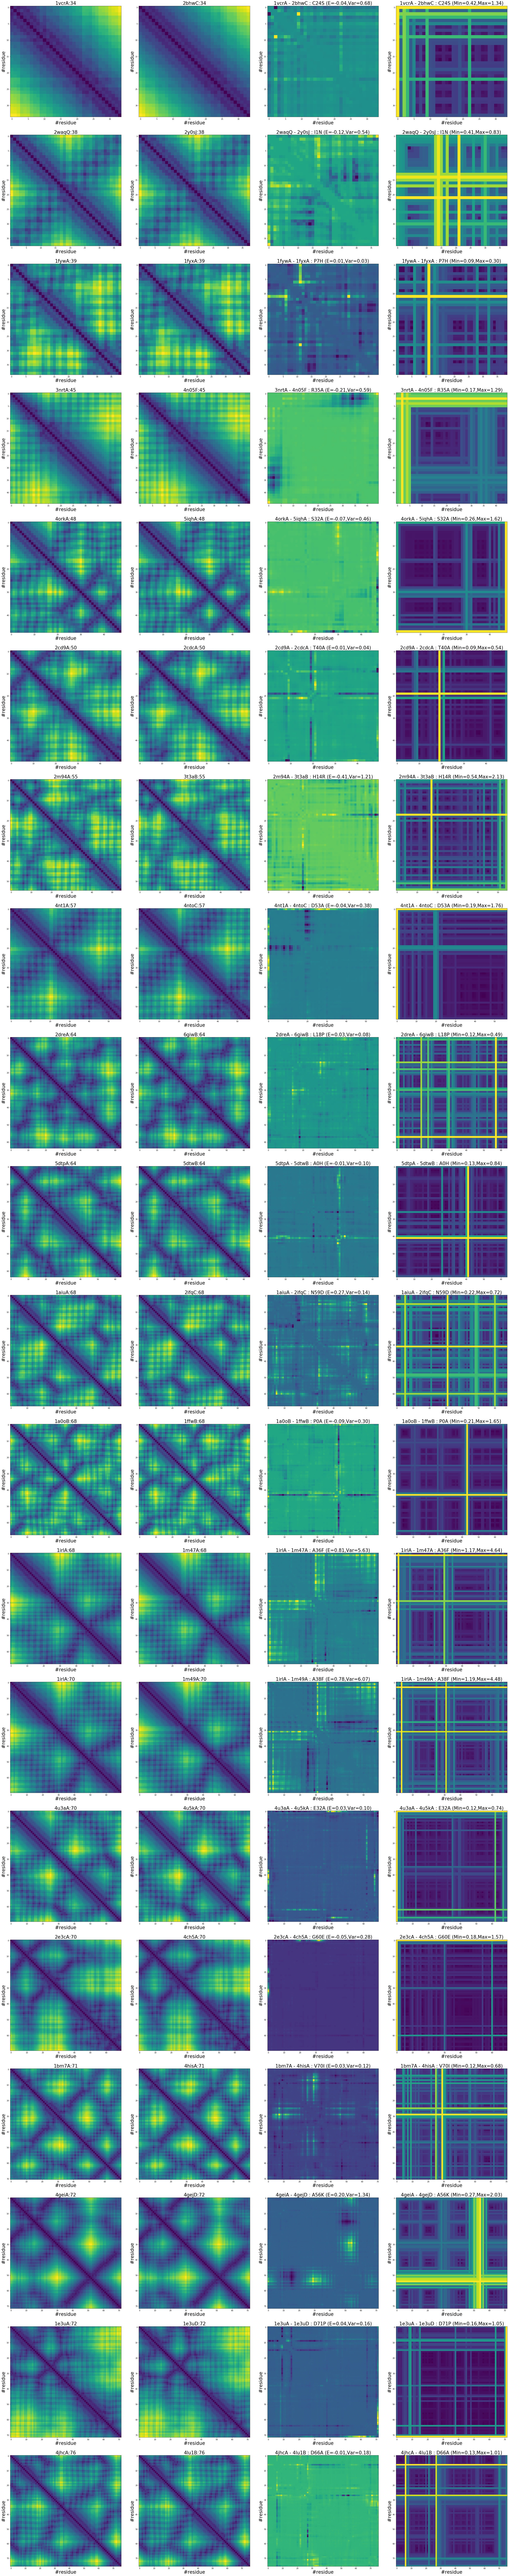

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams

N = 20
rcParams['figure.figsize'] = 40, 40 * (N // 4)

loader = PairsLoader(dataset_pairs)

def display(ax, mat, title):
    ax.set_title(title, fontsize=26)
    ax.set_xlabel('#residue', fontsize=26)
    ax.set_ylabel('#residue', fontsize=26)
    ax.imshow(mat)

f, axarr = plt.subplots(N, 4)

i = 0

while i < N:
    
    meta, data = next(loader)
    
    pdb1, pdb2, seq1, seq2 = meta

    *_, prof1, prof2, mat1, mat2, diff = data
    m1, m2 = mat1.data.numpy(), mat2.data.numpy()
    
    d = diff.data.numpy()[0]
        
    delta = (m1 - m2)
    ddm = (delta) * (np.abs(delta))
    ddm_cutoff = (delta) * (np.abs(delta) >= 0.5)
    msk = compute_weight_matrix(mat1 - mat2).data.numpy()
        
    E = np.mean(delta.ravel())
    Var = np.var(delta.ravel())
    
    E_cutoff = np.mean(ddm_cutoff.ravel())
    Var_cutoff = np.var(ddm_cutoff.ravel())
    
#     if (Var <= 0.1) or (E <= 0.1): continue

    display(axarr[i, 0], m1, '%s:%d' % (pdb1, len(m1)))
    display(axarr[i, 1], m2, '%s:%d' % (pdb2, len(m2)))
        
    display(axarr[i, 2], ddm, '%s - %s : %s%d%s (E=%.2f,Var=%.2f)' 
            % (pdb1, pdb2, seq1[d], d, seq2[d], E, Var))
    
    display(axarr[i, 3], msk, '%s - %s : %s%d%s (Min=%.2f,Max=%.2f)' 
            % (pdb1, pdb2, seq1[d], d, seq2[d], np.min(msk), np.max(msk)))
    
#     display(axarr[i, 3], ddm_cutoff, '%s - %s : %s%d%s (E=%.2f,Var=%.2f)'
#             % (pdb1, pdb2, seq1[d], d, seq2[d], E_cutoff, Var_cutoff))
    
    i += 1
    
plt.tight_layout()

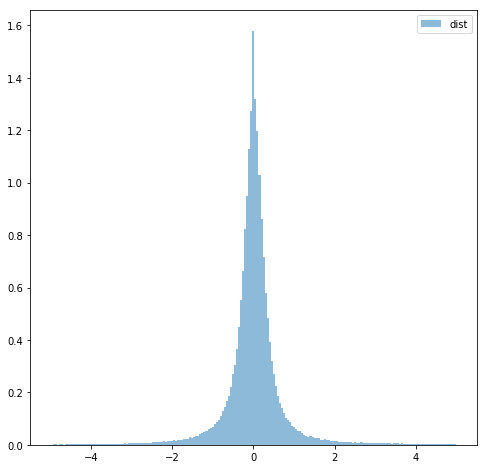

In [26]:
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8


# dataset_pairs = filter_pair_dataset(pickle.load(open('data/ds/pairs-train-9734.pkl', 'rb'), encoding='bytes'), 0.99)
loader = PairsLoader(dataset_pairs)


i = 0
N = 80
hist_arr = []

while i < N:
    
    meta, data = next(loader)
    
    pdb1, pdb2, seq1, seq2 = meta

    *_, prof1, prof2, mat1, mat2, diff = data
    m1, m2 = mat1.data.numpy(), mat2.data.numpy()
    
    d = diff.data.numpy()[0]
        
    delta = (m1 - m2)
    hist_arr.extend(delta.ravel())

    i += 1

bins = np.linspace(-5, 5, 200)

plt.hist(hist_arr, bins, alpha=0.5, label='dist', density=1)

plt.legend(loc='upper right')
plt.show()

In [21]:
import math

E = np.mean(hist_arr)
Var = np.var(hist_arr)

sigma = math.sqrt(Var) 
pdf = lambda x: (math.sqrt(2*math.pi*Var) ** -1) *  math.e ** (-(x**2)/(2*Var))
Var

0.53764534

In [22]:
1./pdf(-2), 1./pdf(0), 1./pdf(2)

(75.83688779552278, 1.8379677093319173, 75.83688779552278)

In [23]:
np.percentile(hist_arr, 90), np.percentile(hist_arr, 50), np.percentile(hist_arr, 90)

(0.5203418731689453, -0.024775028228759766, 0.5203418731689453)